In [2]:
#loading the data
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)
    

In [4]:
len(model['red']) #just checking..

300

In [5]:
#now get our data
import pandas as pd

In [6]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [7]:
data.describe()

asin      brand  color  \
count        16042      15997  16042   
unique       16042       3543   3613   
top     B0754ZLL2R  Anna-Kaci  Black   
freq             1        117   2885   

                                         medium_image_url product_type_name  \
count                                               16042             16042   
unique                                              15185                55   
top     https://images-na.ssl-images-amazon.com/images...             SHIRT   
freq                                                   11             12827   

                                               title formatted_price  
count                                          16042           16042  
unique                                         16041            2788  
top     fashion woman pop muisc shirt black size xl           $19.99  
freq                                               2             474

In [8]:
#THERE ARE 3613 COLORS ...ok
data['color'].unique()

array(['Onyx Black/ Stone', 'White', 'Purple', ..., 'Nantucket Navy',
       'Whitewash', 'River Rock Acid Wash'], dtype=object)

In [10]:
sum(data['brand'].isna())  #some brands are nan.

45

In [11]:
data['brand'].fillna(value = 'not there',inplace = True)

In [12]:
sum(data['color'].isna()) 

0

In [13]:

import numpy
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack


brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

In [14]:
color_features

<16042x1845 sparse matrix of type '<class 'numpy.int64'>'
	with 22446 stored elements in Compressed Sparse Row format>

In [15]:
extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [16]:
extra_features


<16042x5735 sparse matrix of type '<class 'numpy.int64'>'
	with 66179 stored elements in Compressed Sparse Row format>

In [20]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])
import numpy as np
import math
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))


# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [21]:
idf_title_features.shape

(16042, 12609)

In [23]:
idf_title_vectorizer.vocabulary_['xx']

12405

In [29]:

bottleneck_features_train = np.load('16k_data_cnn_features.npy')

In [30]:
bottleneck_features_train.shape

(16042, 25088)

In [34]:

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec






doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [35]:
len(w2v_title_weight),extra_features.shape[0]

(16042, 16042)

In [31]:
w2v_title.shape,extra_features.shape,bottleneck_features_train.shape

((16042, 300), (16042, 5735), (16042, 25088))

In [33]:
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)
df_asins = list(data['asin'])


In [38]:
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


import warnings
from bs4 import BeautifulSoup

import seaborn as sns

In [39]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)






def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [41]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

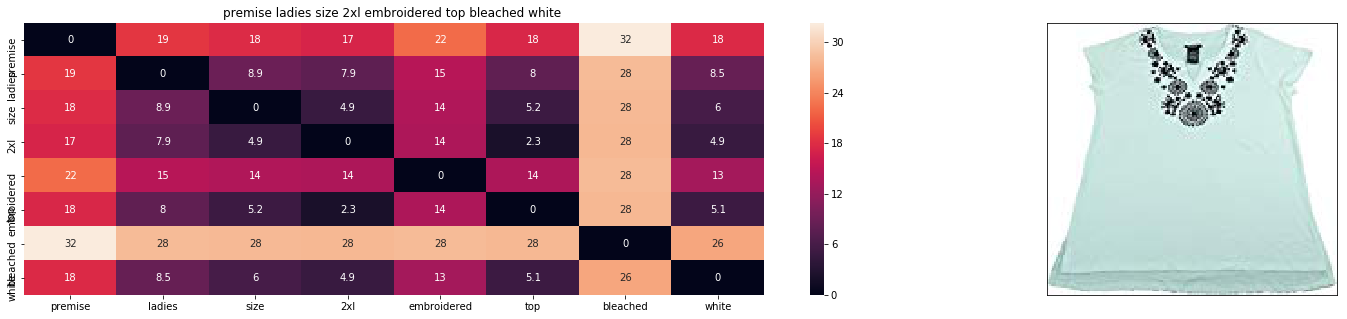

ASIN : B01M0IDUCV
Brand : Premise
euclidean distance from input : 0.03125


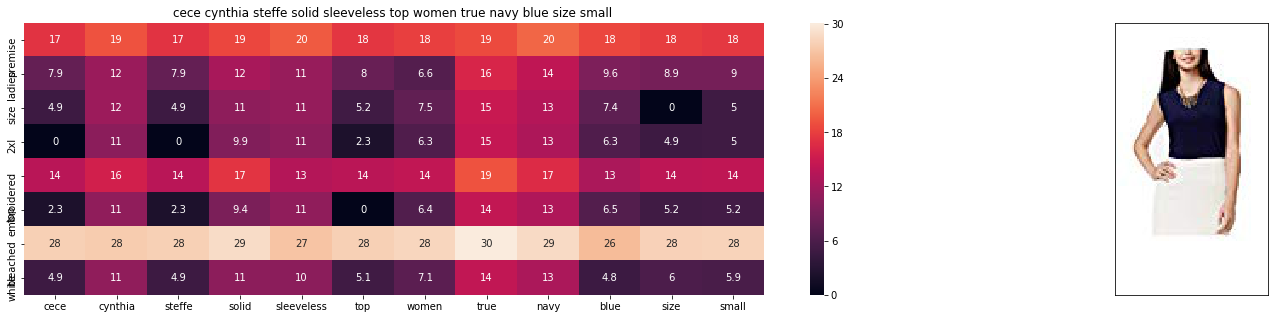

ASIN : B01N4NQ7LX
Brand : CeCe by Cynthia Steffe
euclidean distance from input : 16.945495939254762


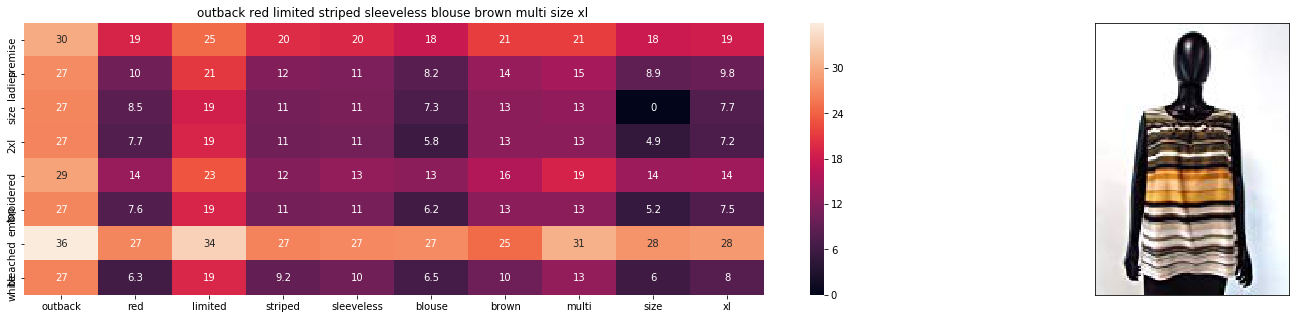

ASIN : B01IU645VU
Brand : Outback Red
euclidean distance from input : 22.781414881086516


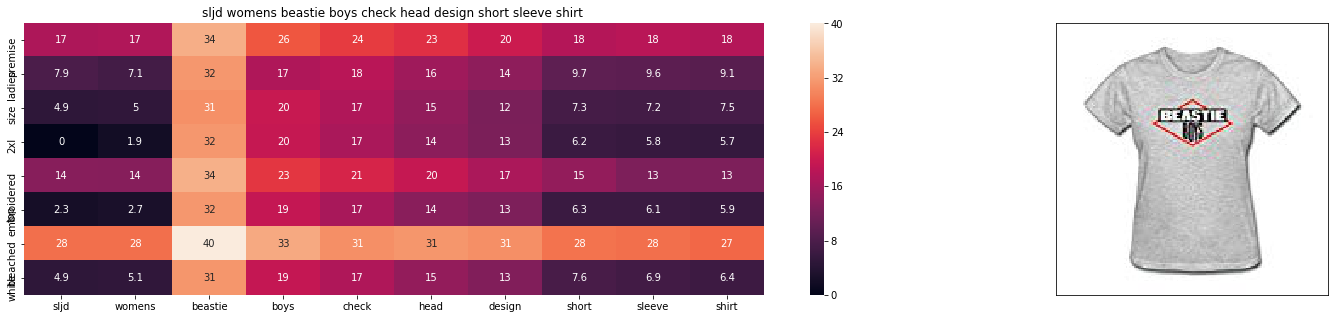

ASIN : B01FQLKKMK
Brand : SLJD
euclidean distance from input : 24.408482923841643


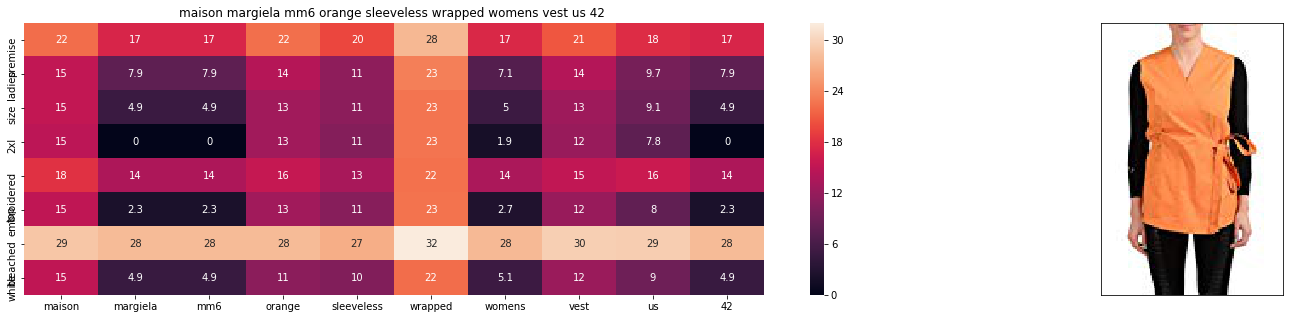

ASIN : B01MXI5L4G
Brand : Maison Margiela MM6
euclidean distance from input : 25.673167004919218


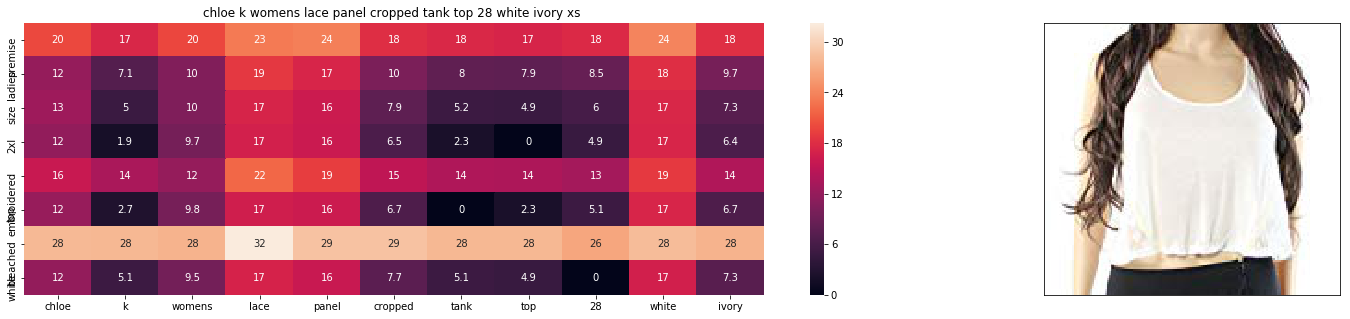

ASIN : B071VZCT5W
Brand : Chloe K.
euclidean distance from input : 25.99281289577484


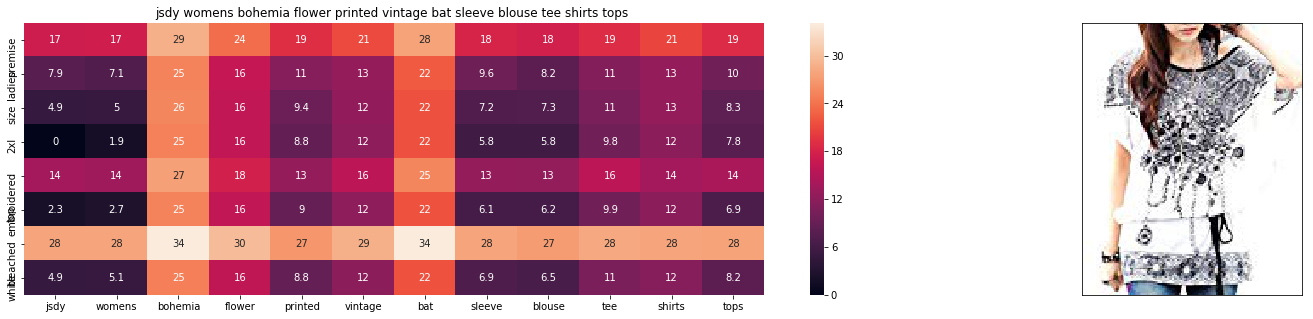

ASIN : B00L8RE3PC
Brand : JSDY-Cloth
euclidean distance from input : 26.05510320663452


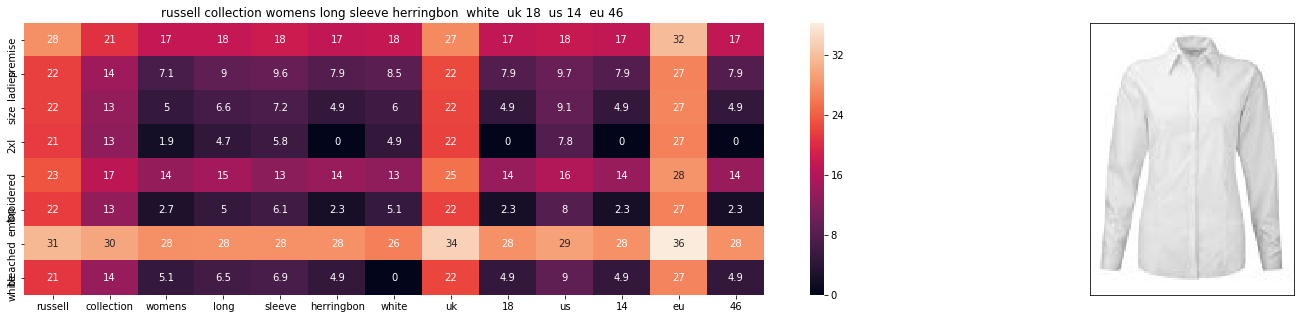

ASIN : B00K77AN5S
Brand : Russell Collection
euclidean distance from input : 26.09391882419586


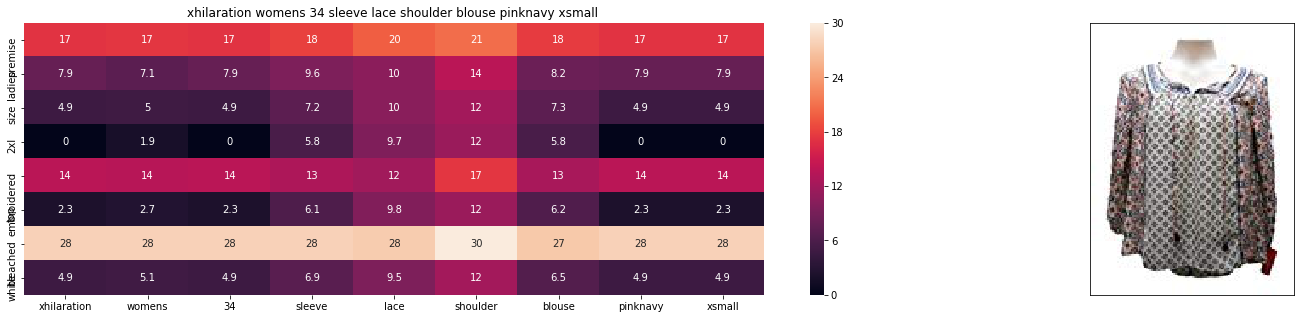

ASIN : B06ZYLKPRT
Brand : Xhilaration
euclidean distance from input : 26.14074919825146


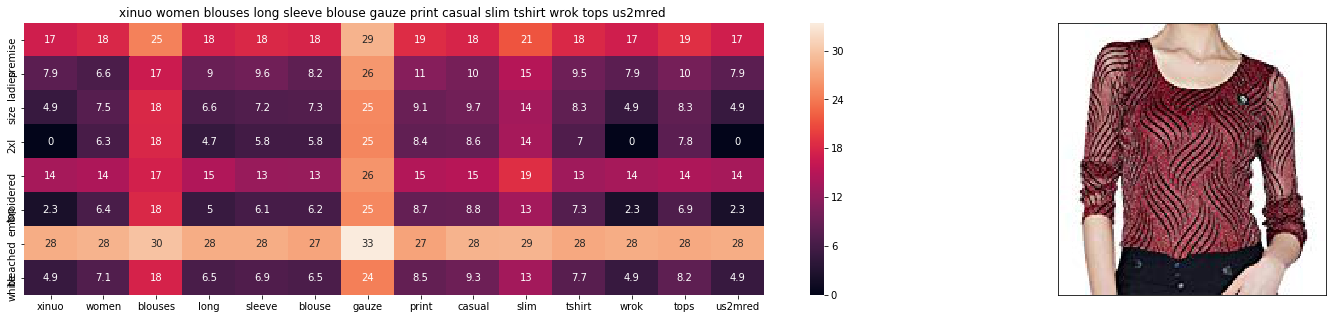

ASIN : B01MU874KK
Brand : XINUO
euclidean distance from input : 26.156251257052386


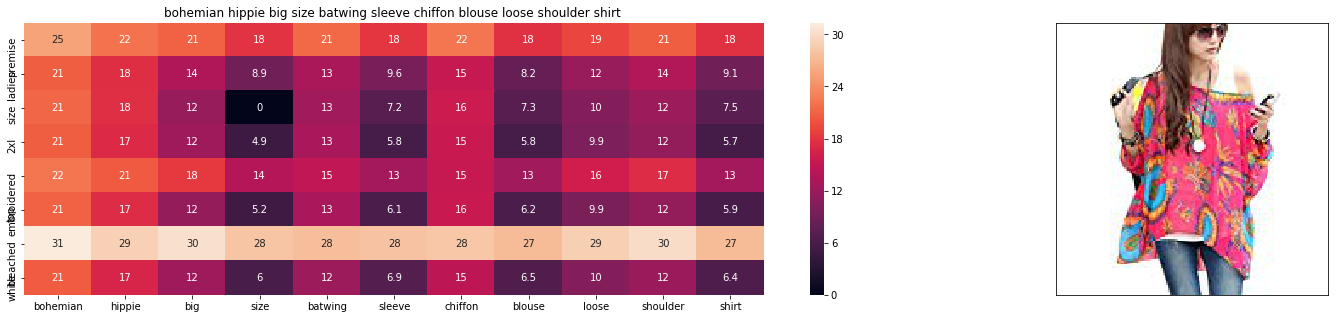

ASIN : B00YC92VRU
Brand : Display Promotion
euclidean distance from input : 26.162980859866106


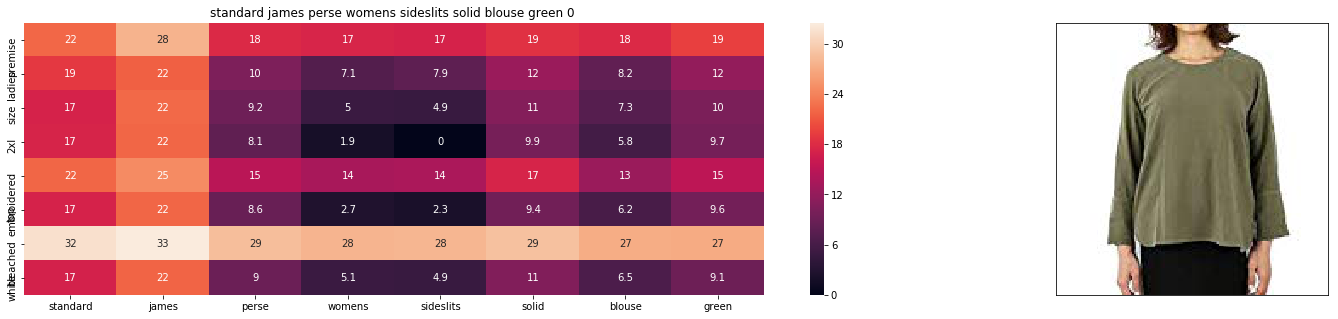

ASIN : B071LMW4YG
Brand : Standard James Perse
euclidean distance from input : 26.19173146758096


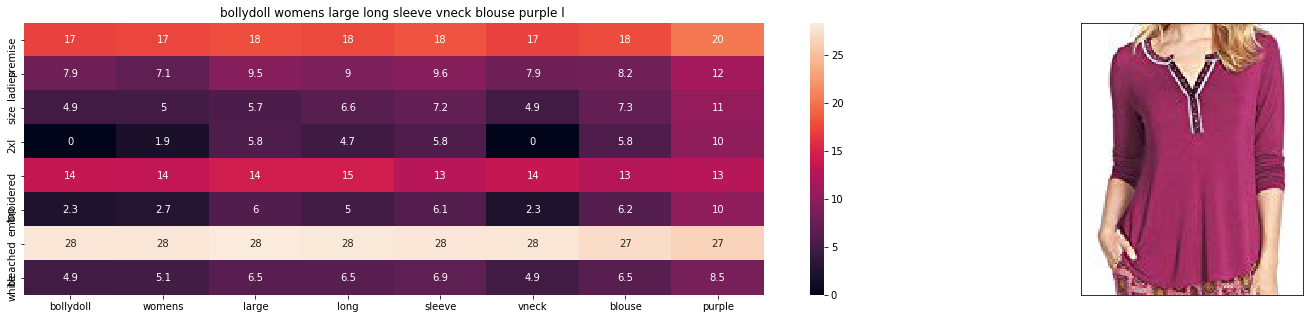

ASIN : B074MJPLCB
Brand : BollyDoll
euclidean distance from input : 26.202330535044634


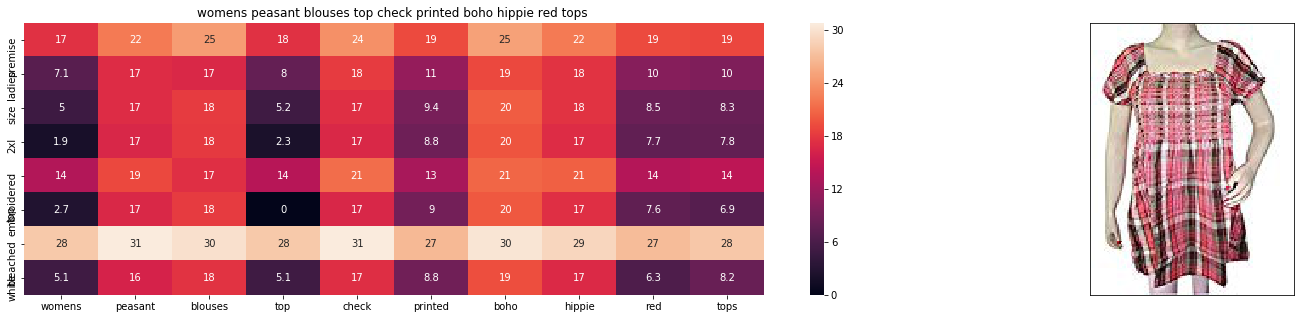

ASIN : B01MXMG6KB
Brand : Mogul Interior
euclidean distance from input : 26.21506868010113


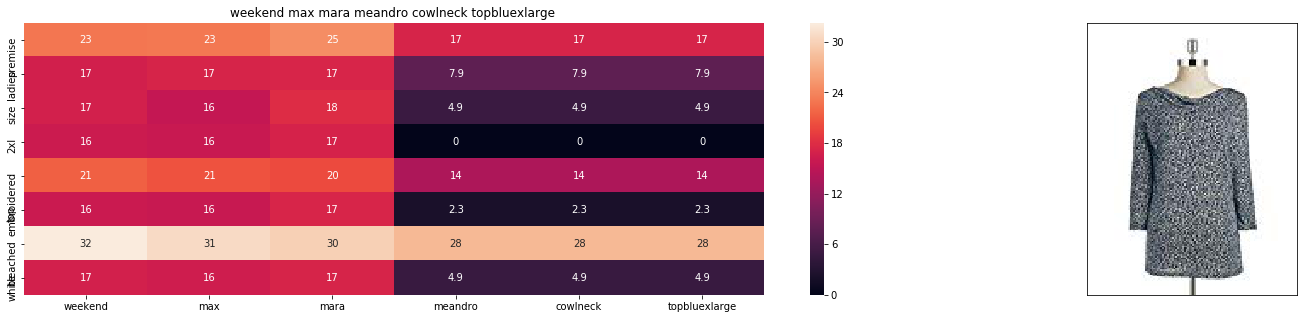

ASIN : B01MG83UB4
Brand : MaxMara
euclidean distance from input : 26.350200360407793


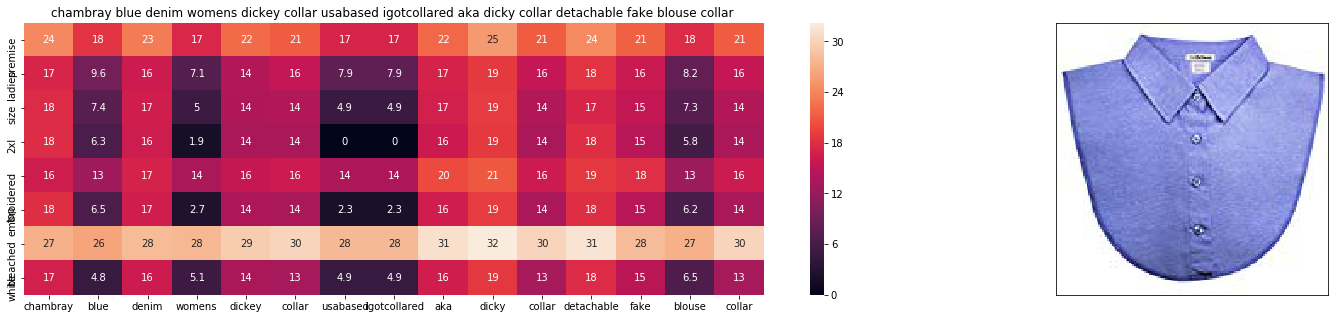

ASIN : B01MQWKWME
Brand : IGotCollared
euclidean distance from input : 26.371402397489714


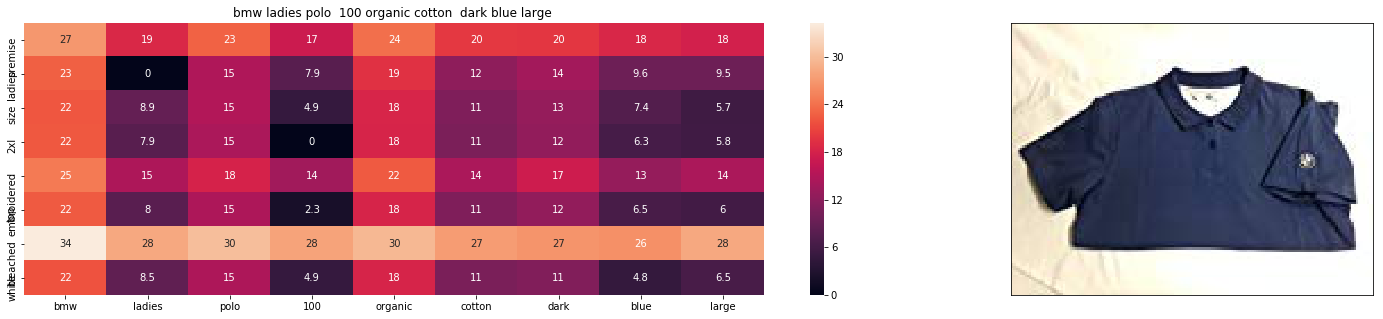

ASIN : B0060MKVX8
Brand : not there
euclidean distance from input : 26.40524950995595


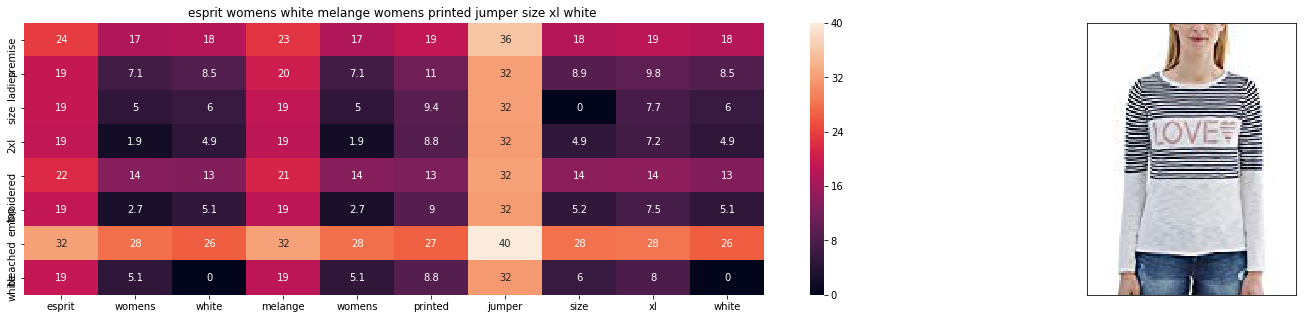

ASIN : B01MSZ1EO7
Brand : Esprit
euclidean distance from input : 26.416069641447233


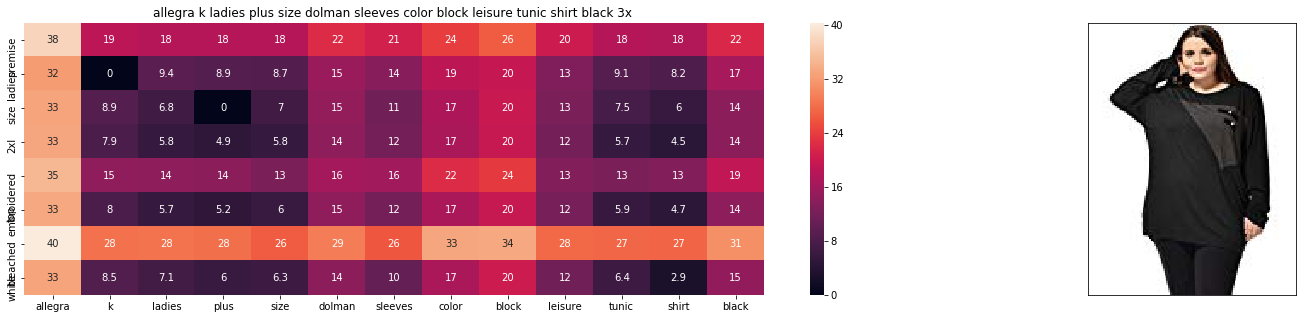

ASIN : B00D2J5HPO
Brand : Kaia
euclidean distance from input : 26.46126157580849


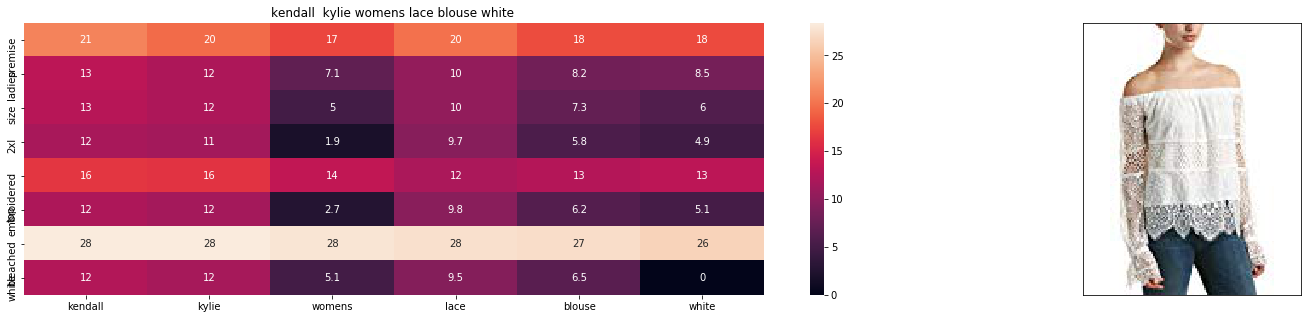

ASIN : B071KG15YM
Brand : KENDALL + KYLIE
euclidean distance from input : 26.462349039369318


In [42]:
#let's give cnn features most weight ,followed by idf-w2v then color+brand


w_cnn = 0.5
w_title = 0.3
w_cb = 0.2

def idf_w2v_brand_cnn(doc_id, w_cnn, w_title,w_cb ,num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    doc_id = asins.index(df_asins[doc_id])
    cnn_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w_title * idf_w2v_dist +  w_cb * ex_feat_dist + w_cnn*cnn_dist)/float(w_cb+w_cnn+w_title)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand_cnn(12566, 0.5,0.3,0.2, 20)


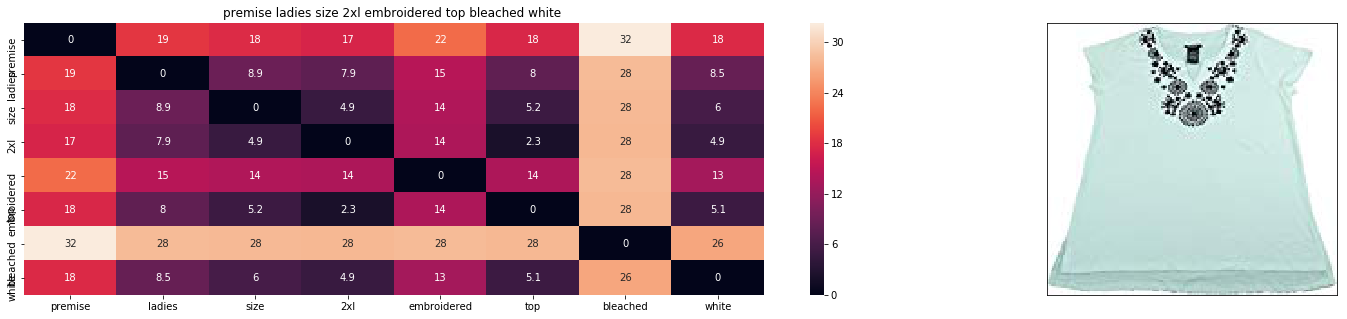

ASIN : B01M0IDUCV
Brand : Premise
euclidean distance from input : 0.012500000186264515


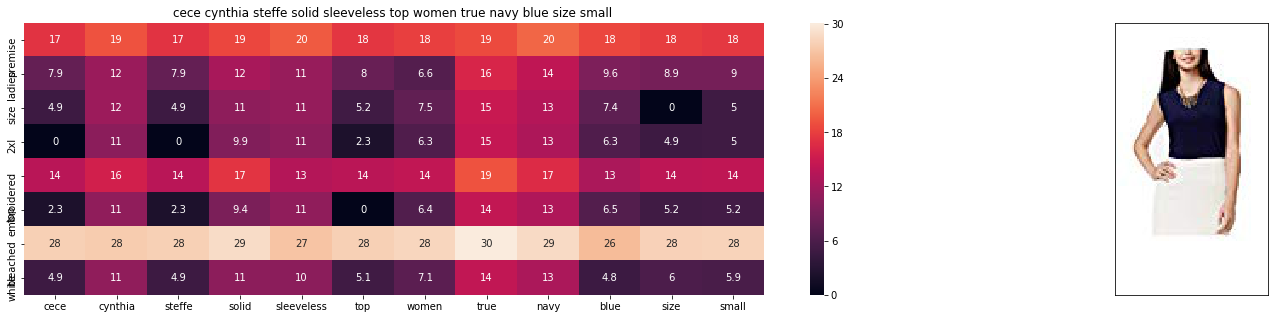

ASIN : B01N4NQ7LX
Brand : CeCe by Cynthia Steffe
euclidean distance from input : 9.25093469619751


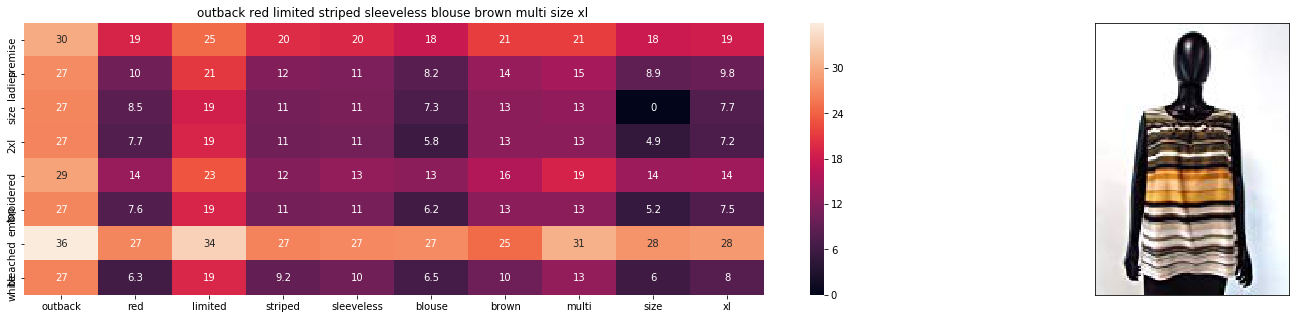

ASIN : B01IU645VU
Brand : Outback Red
euclidean distance from input : 12.024817004537747


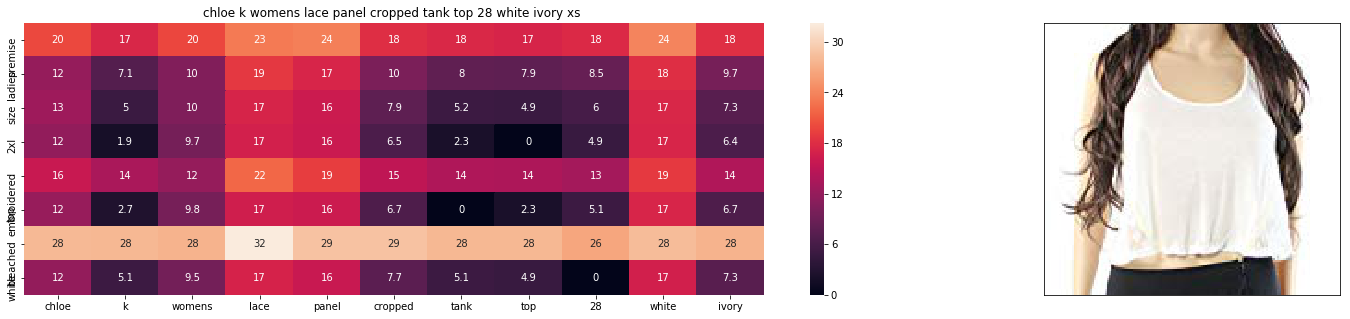

ASIN : B071VZCT5W
Brand : Chloe K.
euclidean distance from input : 12.878731870651245


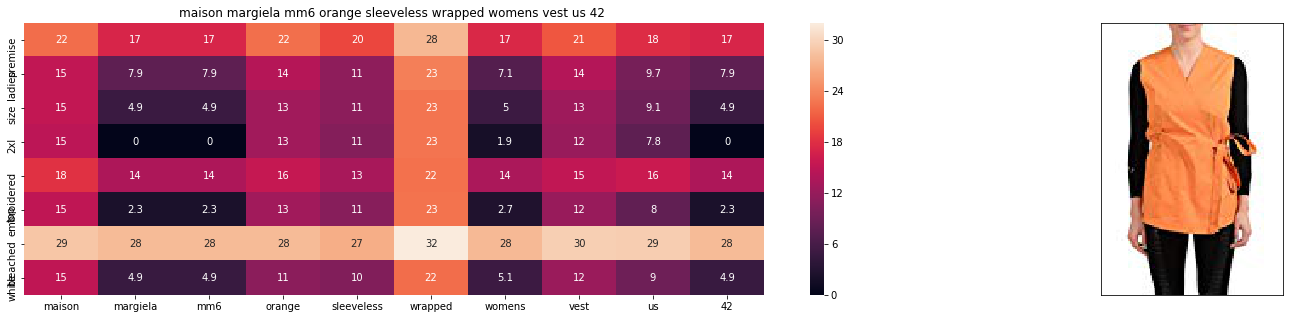

ASIN : B01MXI5L4G
Brand : Maison Margiela MM6
euclidean distance from input : 12.911175027227566


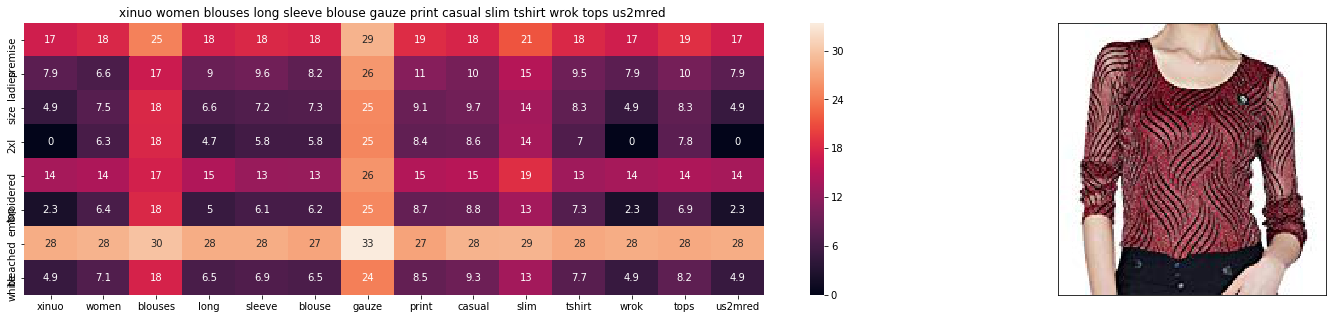

ASIN : B01MU874KK
Brand : XINUO
euclidean distance from input : 12.96589011489388


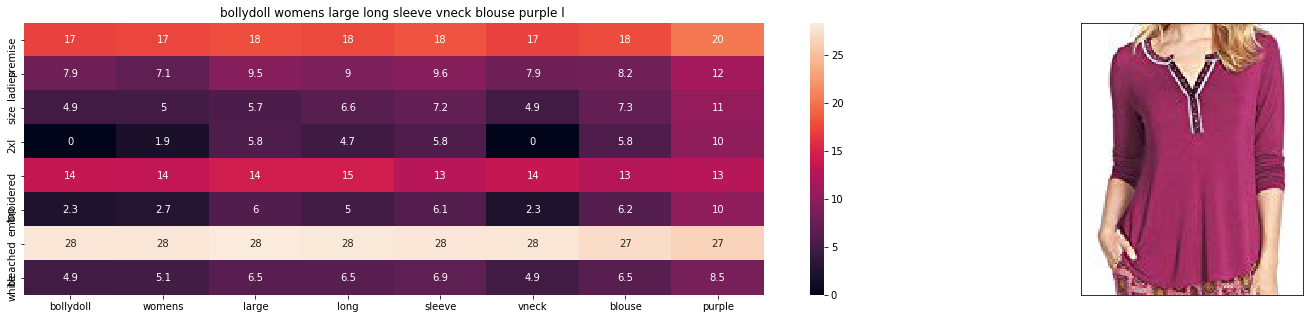

ASIN : B074MJPLCB
Brand : BollyDoll
euclidean distance from input : 13.018726771464314


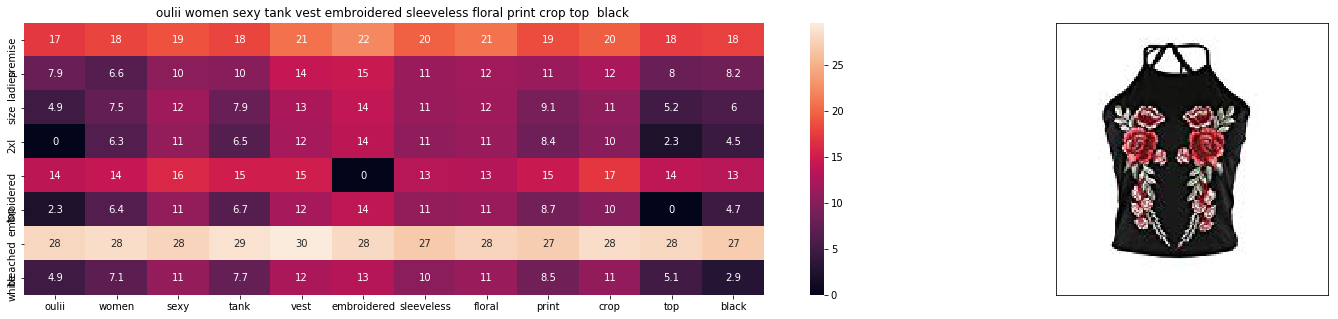

ASIN : B074KZ12G1
Brand : OULII
euclidean distance from input : 13.043786233057942


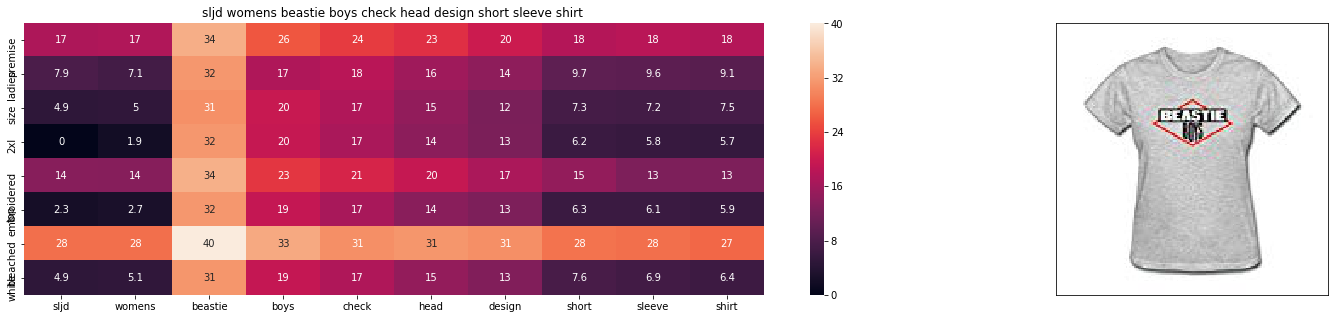

ASIN : B01FQLKKMK
Brand : SLJD
euclidean distance from input : 13.087666049337553


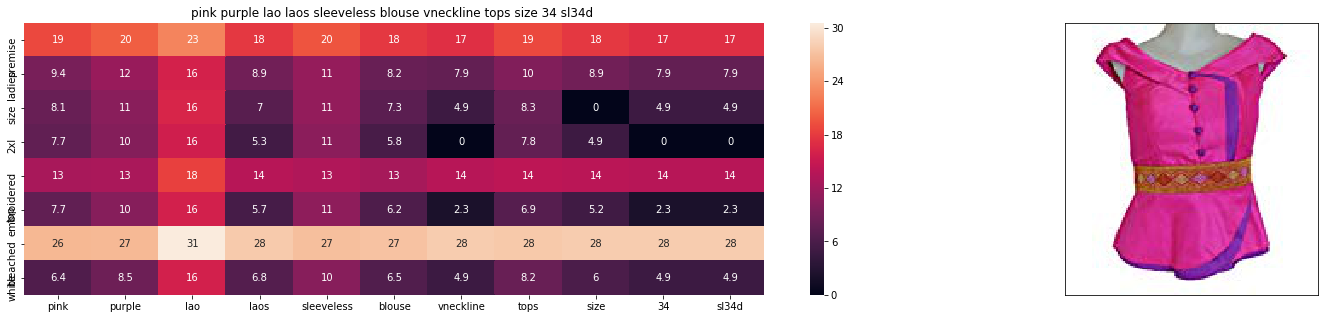

ASIN : B074KCYKJP
Brand : Nanon
euclidean distance from input : 13.167440360178913


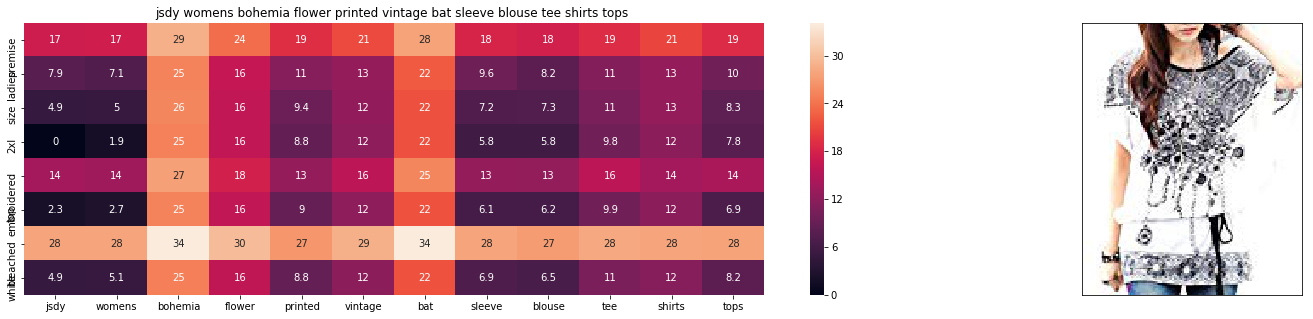

ASIN : B00L8RE3PC
Brand : JSDY-Cloth
euclidean distance from input : 13.174629592895508


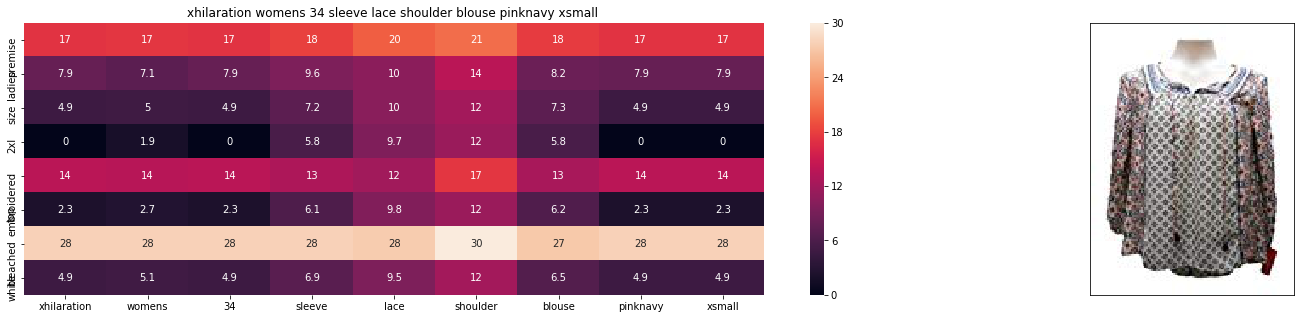

ASIN : B06ZYLKPRT
Brand : Xhilaration
euclidean distance from input : 13.179094535165522


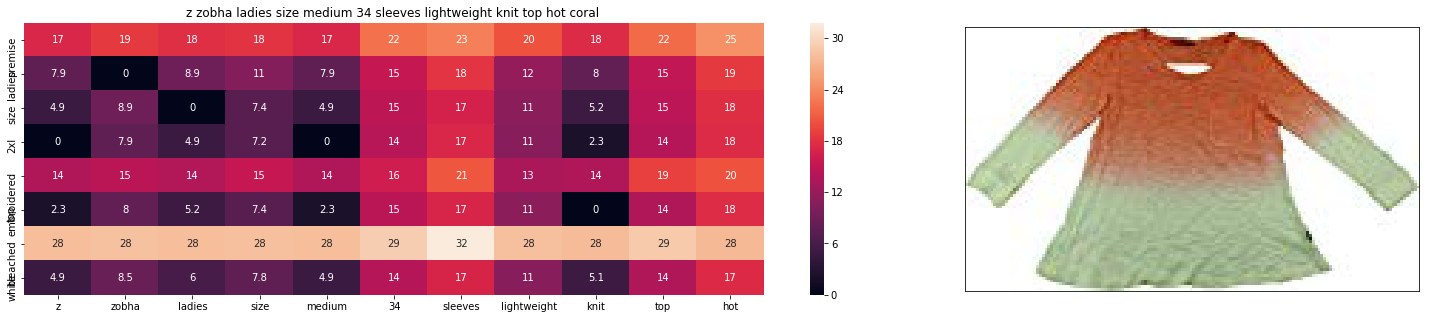

ASIN : B01FY92914
Brand : Z by Zobha
euclidean distance from input : 13.236831441259548


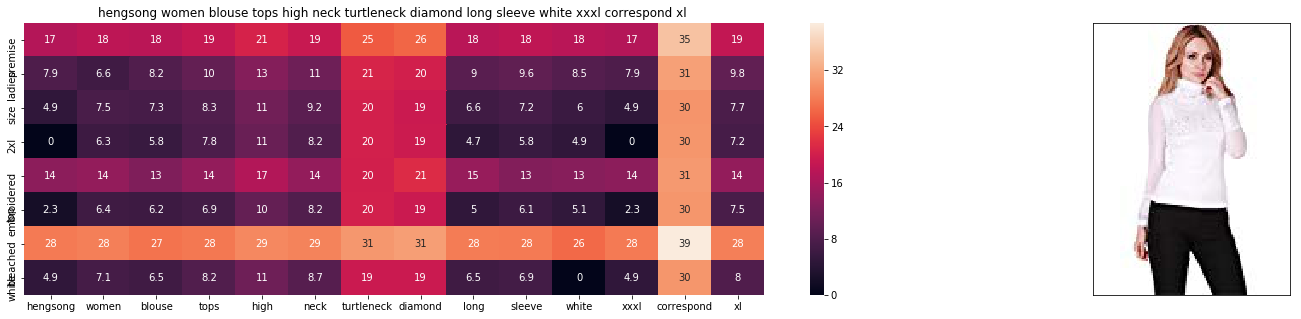

ASIN : B01INBE5WQ
Brand : HENGSONG
euclidean distance from input : 13.24304736282298


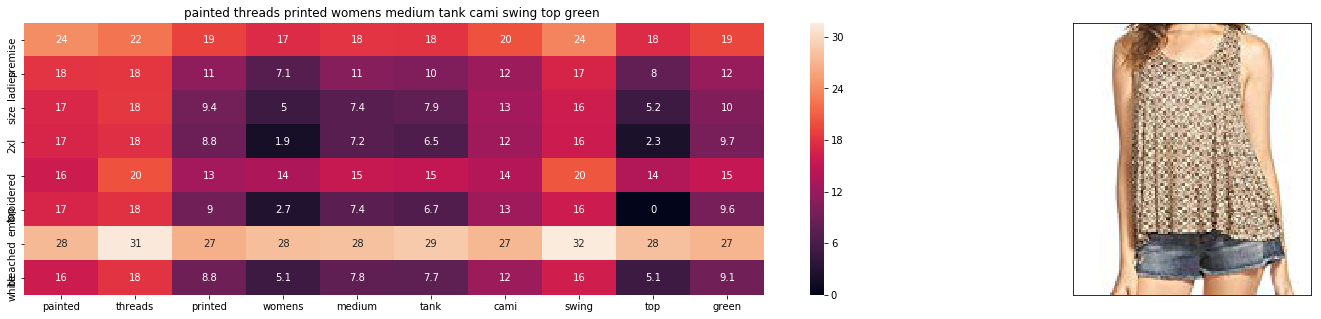

ASIN : B06XXKD9JR
Brand : Painted Threads
euclidean distance from input : 13.244397860818598


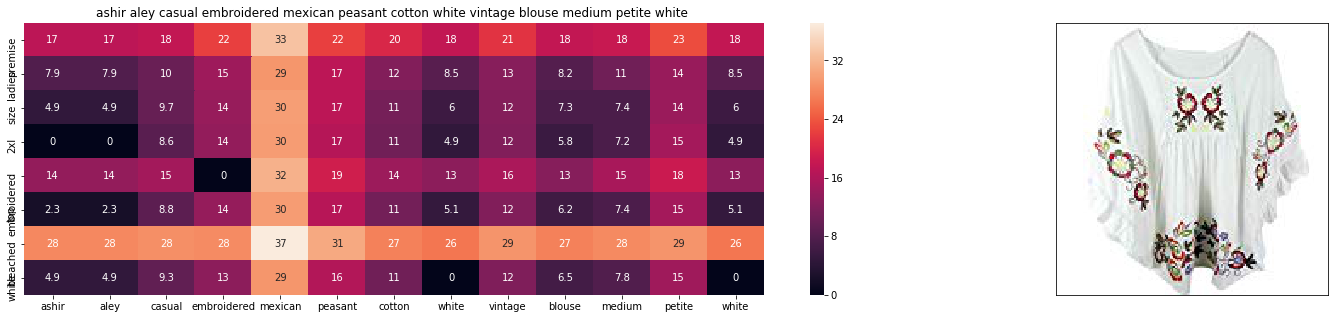

ASIN : B00VG90BUI
Brand : Ashir Aley
euclidean distance from input : 13.250337505340577


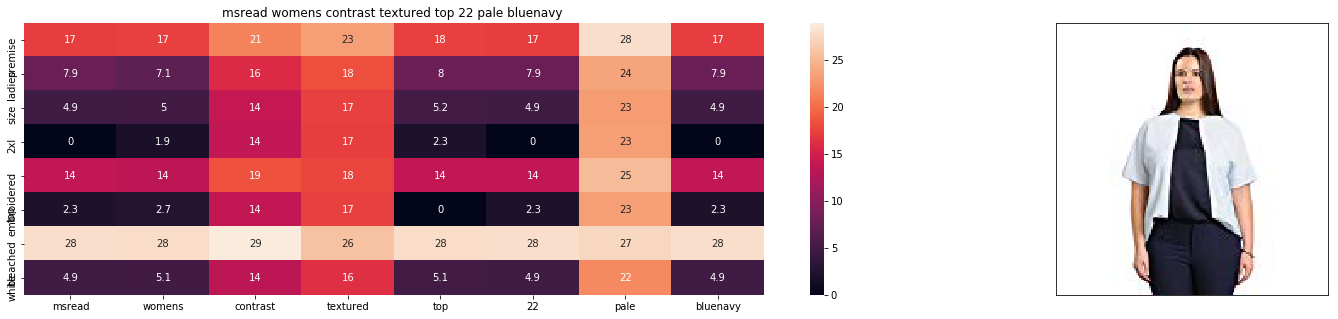

ASIN : B01CYL8C98
Brand : MS.READ
euclidean distance from input : 13.251201067115376


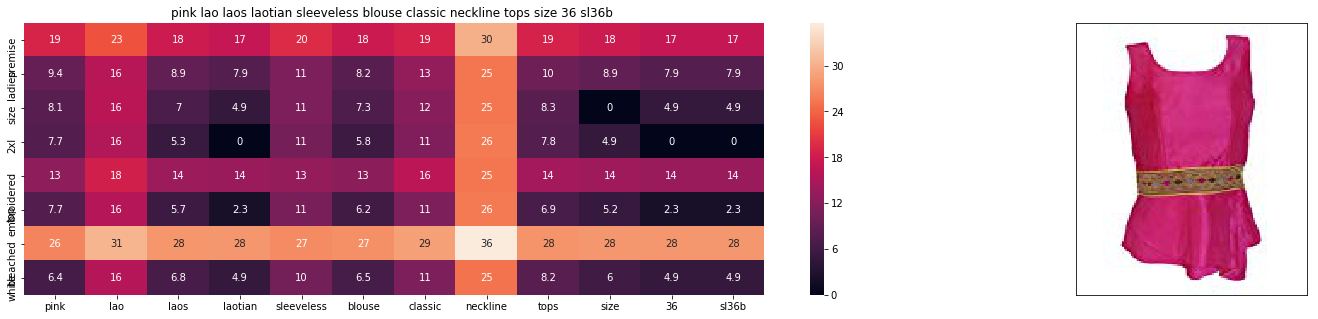

ASIN : B074JCDGWM
Brand : Nanon
euclidean distance from input : 13.256262963404621


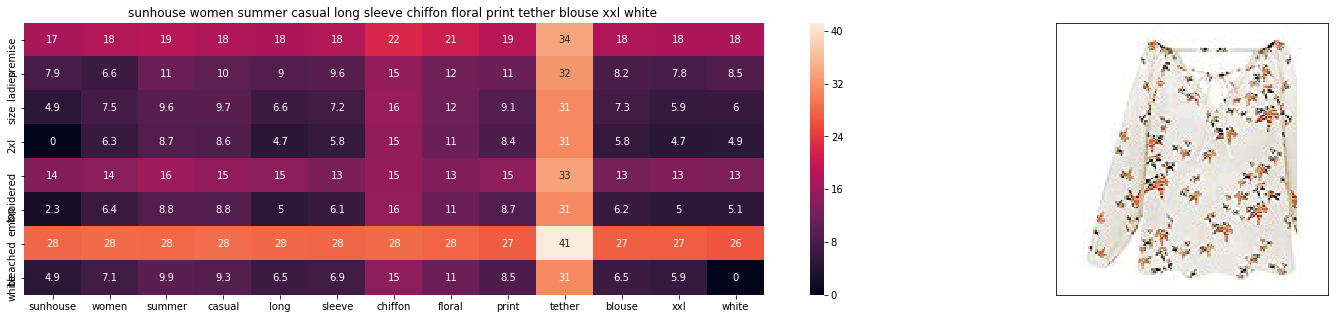

ASIN : B074337SFR
Brand : Sunhouse
euclidean distance from input : 13.258756762999981


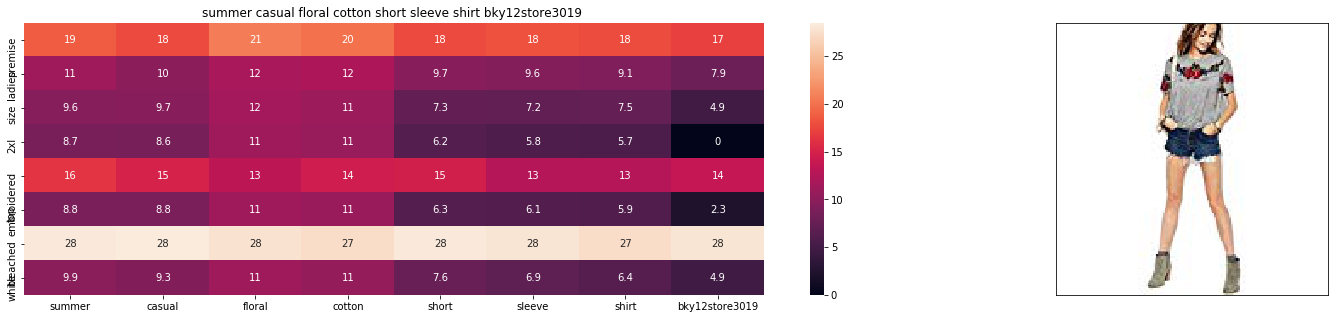

ASIN : B015LV4N3W
Brand : bankhunyabangyai store
euclidean distance from input : 13.259380799585077


In [43]:


idf_w2v_brand_cnn(12566, 0.2,0.6,0.2, 20)

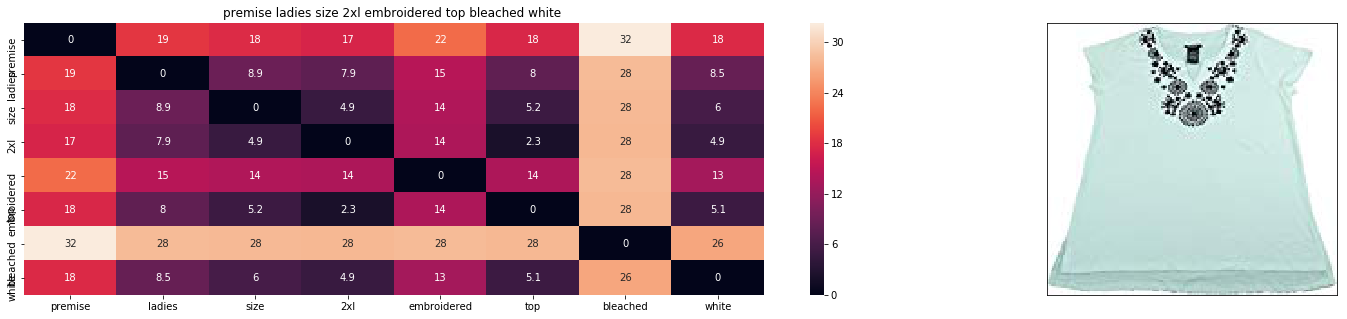

ASIN : B01M0IDUCV
Brand : Premise
euclidean distance from input : 0.0


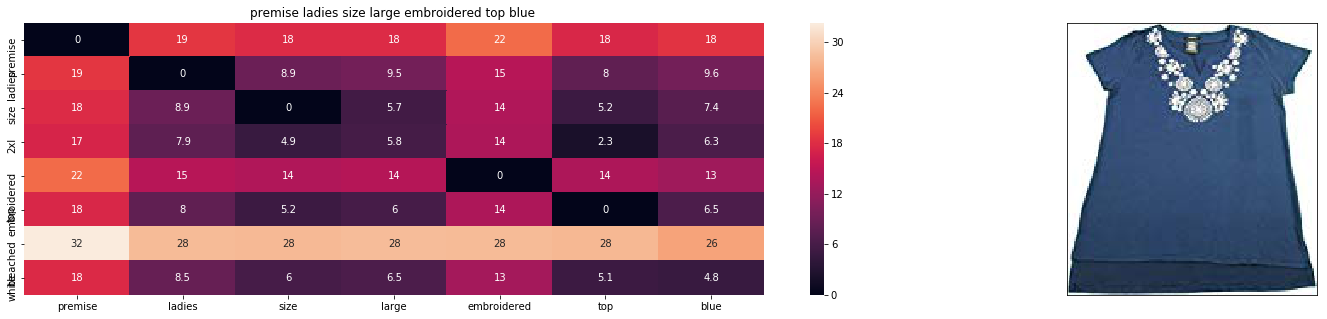

ASIN : B01LFDIDBS
Brand : Premise
euclidean distance from input : 3.4931254386901855


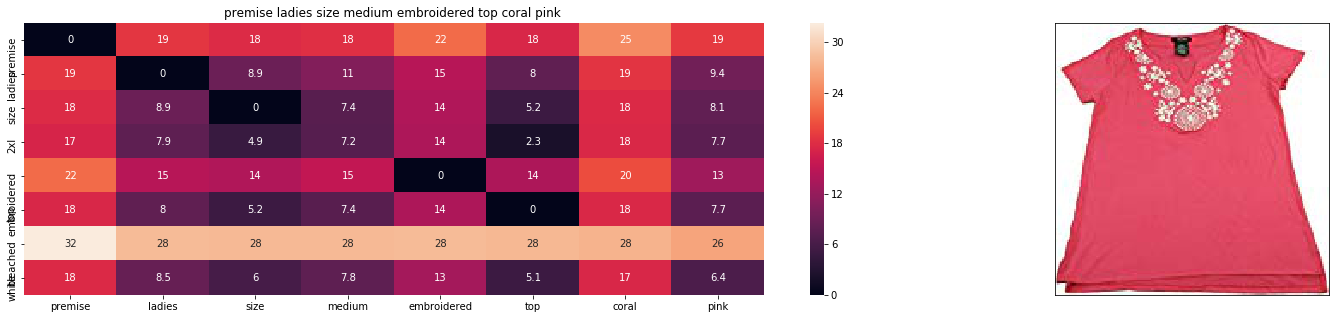

ASIN : B01LWUIZYJ
Brand : Premise
euclidean distance from input : 3.630368709564209


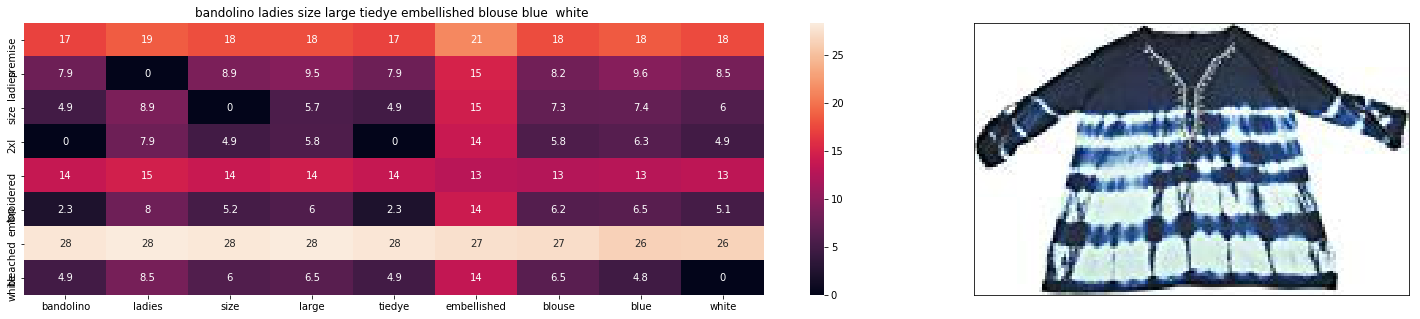

ASIN : B01KP7KZI4
Brand : Bandolino
euclidean distance from input : 4.084248065948486


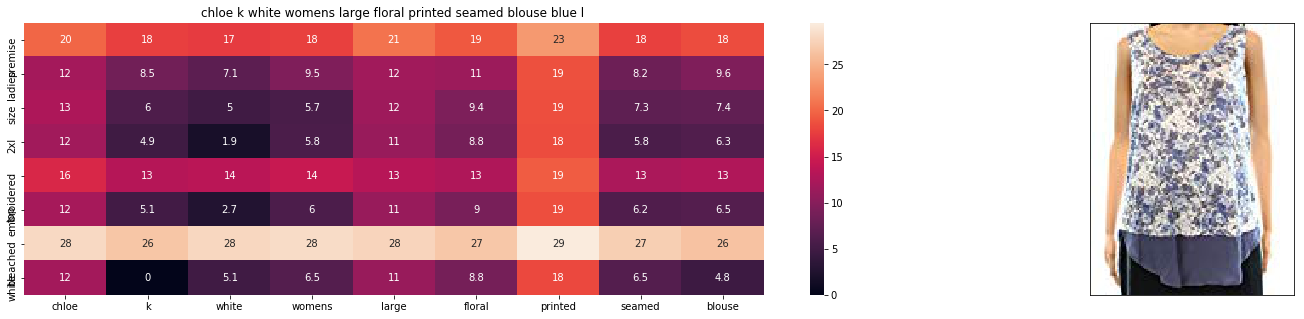

ASIN : B074P8RKKB
Brand : Chloe K.
euclidean distance from input : 4.135766506195068


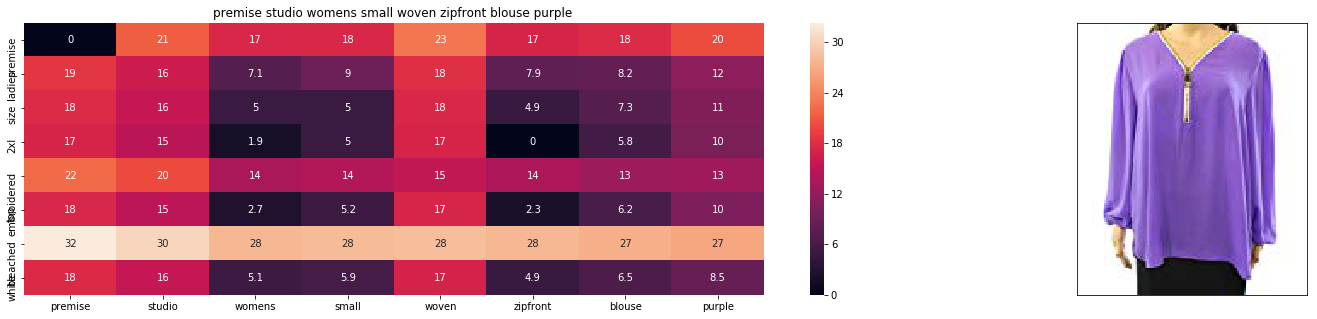

ASIN : B074P923YD
Brand : Premise Studio
euclidean distance from input : 4.142604827880859


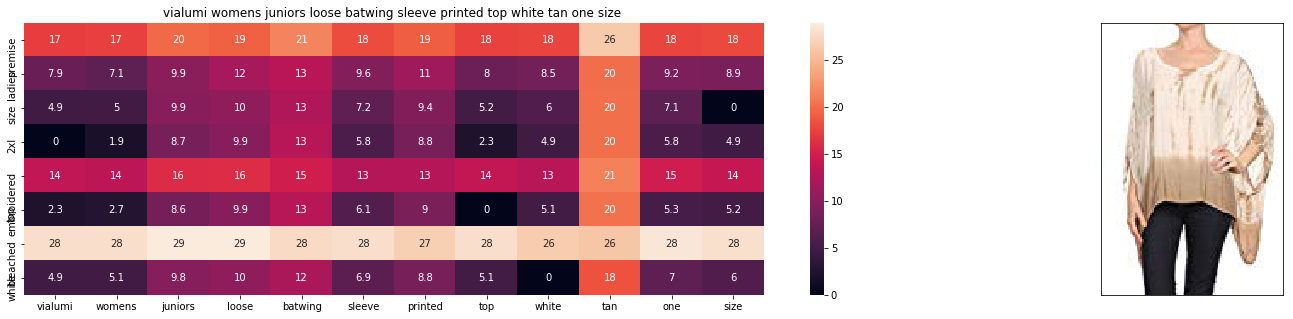

ASIN : B01BN4F3VW
Brand : Vialumi
euclidean distance from input : 4.196934223175049


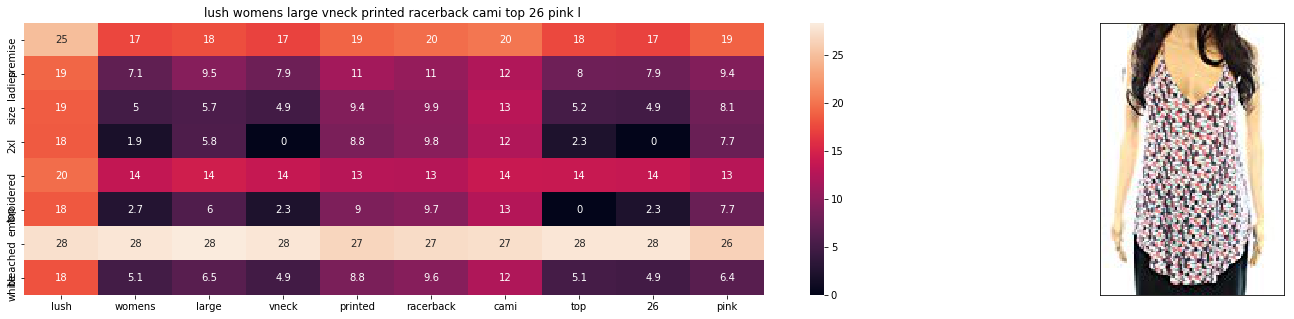

ASIN : B01LY8FVFA
Brand : Lush Clothing
euclidean distance from input : 4.204068660736084


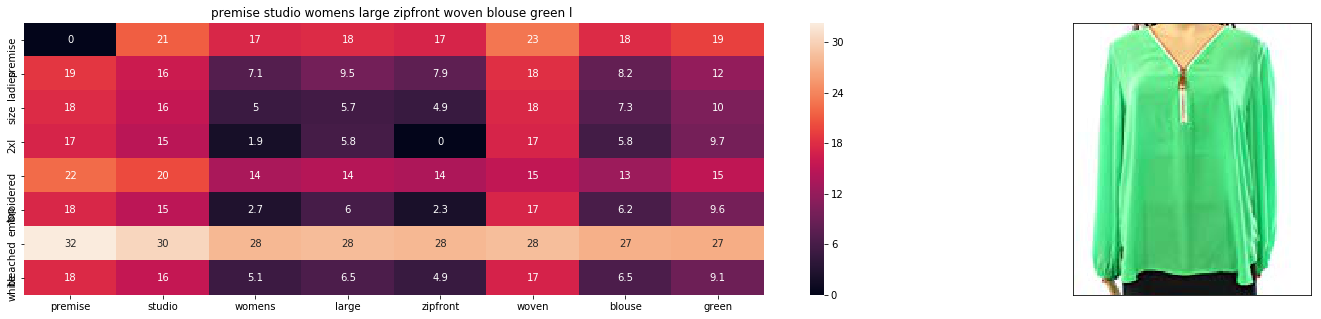

ASIN : B074P8NF7V
Brand : Premise Studio
euclidean distance from input : 4.2159600257873535


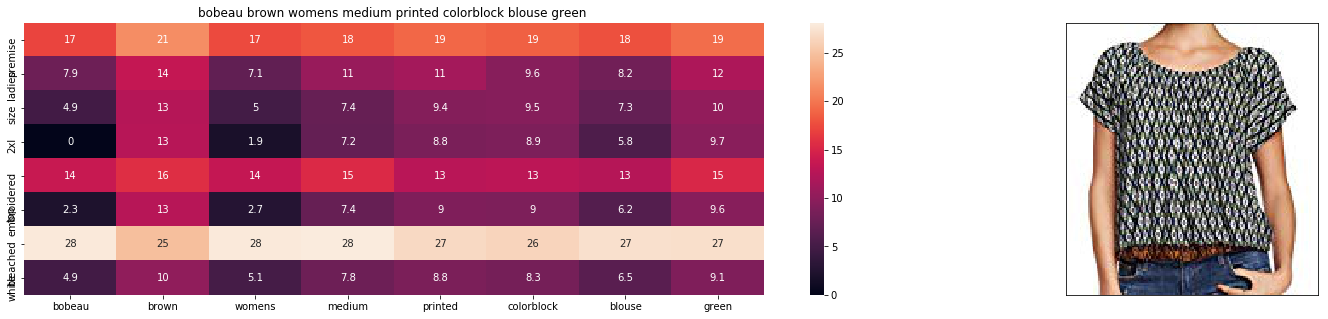

ASIN : B01LXWSQP0
Brand : Bobeau
euclidean distance from input : 4.246901035308838


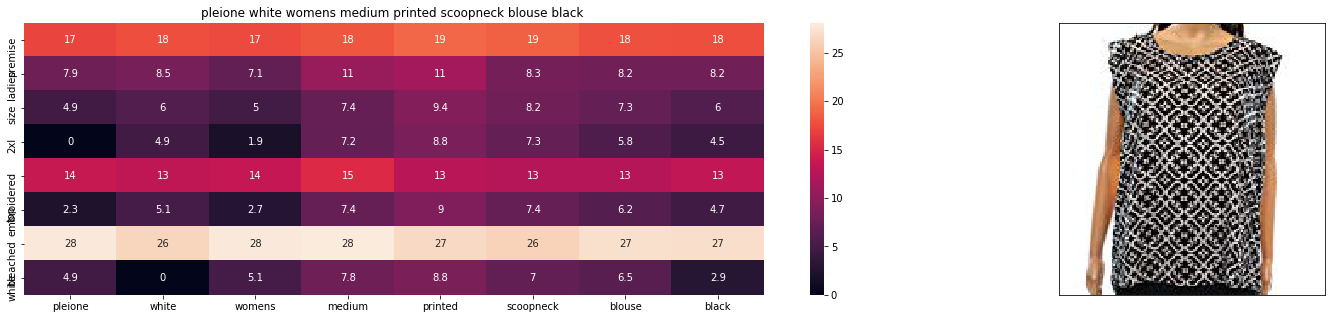

ASIN : B074VB3LTP
Brand : Pleione
euclidean distance from input : 4.248535633087158


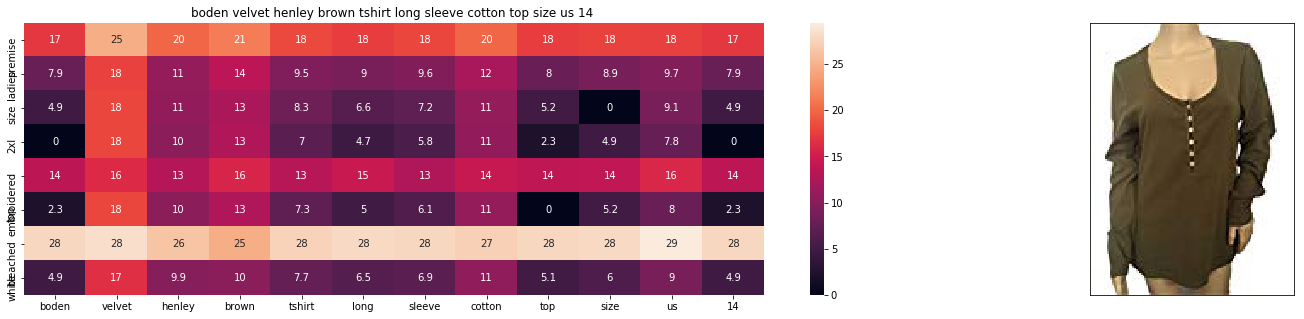

ASIN : B072DRJ5PK
Brand : BODEN
euclidean distance from input : 4.249417781829834


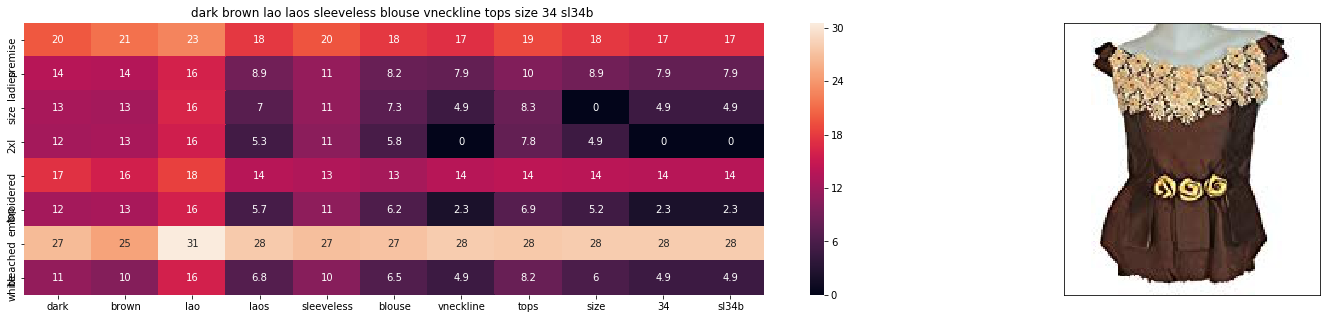

ASIN : B074J48RGW
Brand : Nanon
euclidean distance from input : 4.25518274307251


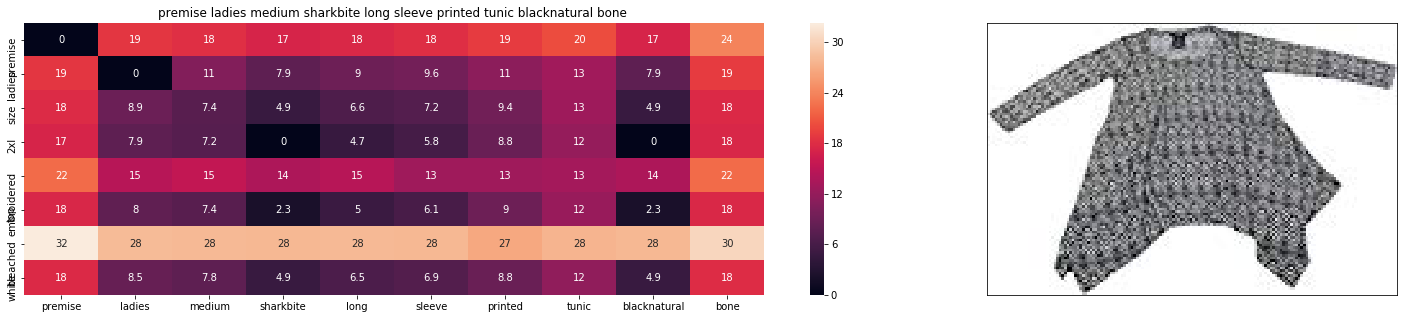

ASIN : B01DFU8GZM
Brand : Premise
euclidean distance from input : 4.2690606117248535


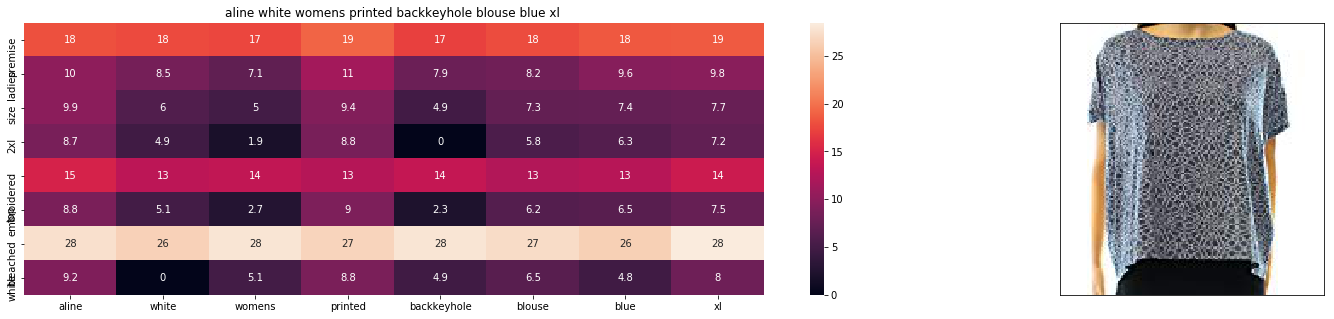

ASIN : B073S7PCGH
Brand : a_line
euclidean distance from input : 4.274749279022217


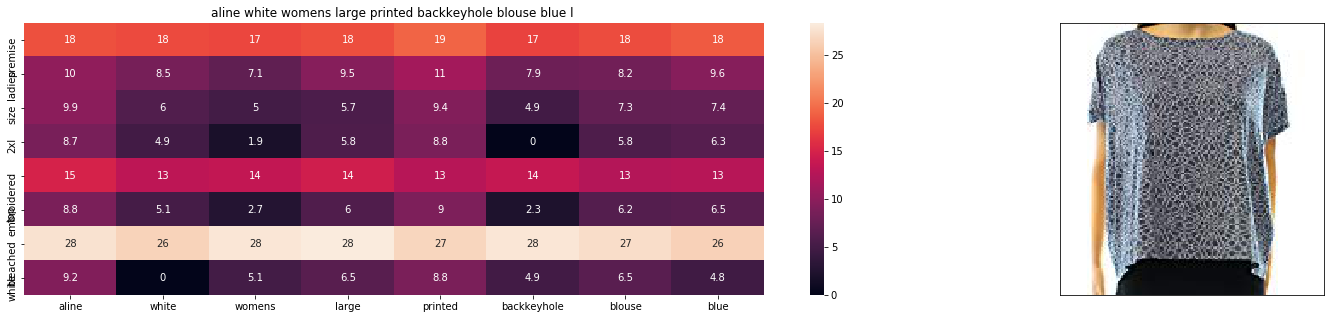

ASIN : B073S6QWP1
Brand : a_line
euclidean distance from input : 4.279412269592285


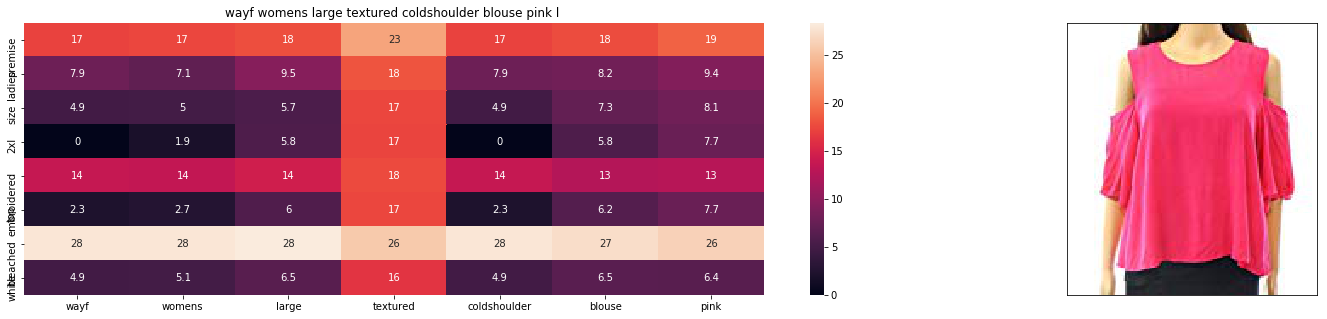

ASIN : B0719L6BN2
Brand : WAYF
euclidean distance from input : 4.28873348236084


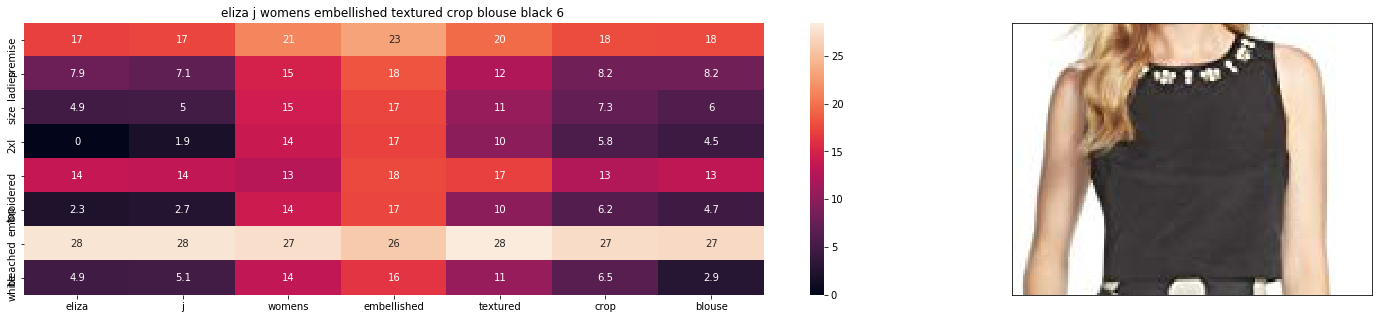

ASIN : B0757ZSHH3
Brand : Eliza J
euclidean distance from input : 4.293206691741943


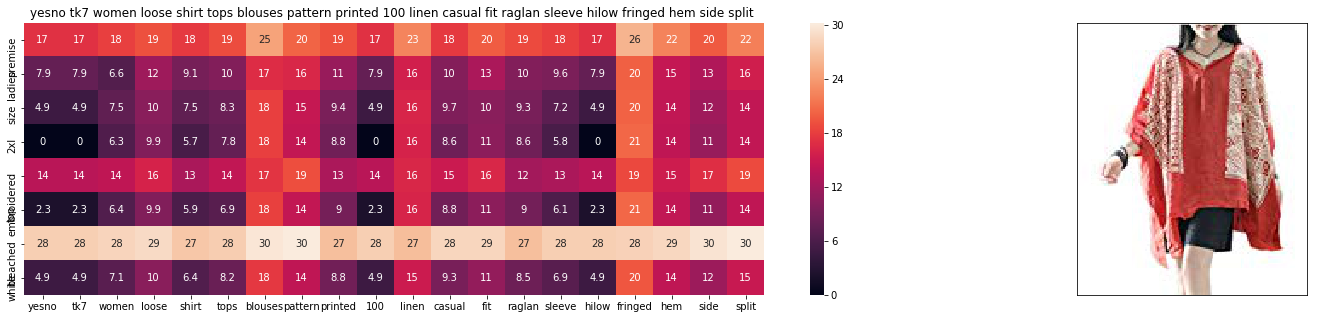

ASIN : B073QM7BFL
Brand : YESNO
euclidean distance from input : 4.298129558563232


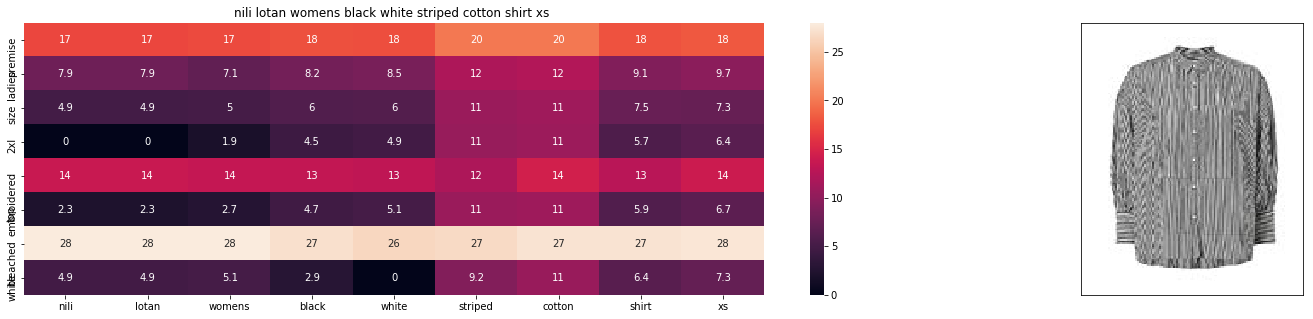

ASIN : B06XGQJG1K
Brand : Nili Lotan
euclidean distance from input : 4.307354927062988


In [44]:

idf_w2v_brand_cnn(12566, 0,1,0, 20)